1. Data Preparation and Exploration

In [51]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.linear_model import LogisticRegression  #Logistic Regression
import xgboost as xgb #XGBoost

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

import pickle

In [52]:

#LOAD DATASET

def load_and_prepare_diabetes_data(filepath):
    #Load Data
    df = pd.read_csv(filepath)

    #Show Dataset info
    print(f"Dataset Shape (# of rows/columns) {df.shape} ")
    print(f"Dataset desc: {df.describe()}")

    #check missing values
    print(f"\n Missing values: {df.isnull().sum()}")

    #check for zero values in the specific columns: (Glucose, BloodPressure, SkinThickness, Insulin, BMI)
    # and get the count of rows where the column value is zero
    for column in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
        # Count the number of zeros in the column
        column_zero_count = len(df[df[column]==0])
        # Print the result in percentages with 2 decimals
        print(f"{column}: {column_zero_count} zeros ({column_zero_count/len(df)*100:.2f}%)")
    
    #Handle zeros, first replace zeros with NaN, then replace the NaN with Median vlaue
    columns_to_process = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    df_processed = df.copy() 
    for column in columns_to_process:
        #replace zeros with NaN
        df_processed[column] = df_processed[column].replace(0, np.nan)
        #replace NaN with median
        #calculate meadian of non-zero values
        median_value = df_processed[ df_processed[column]!=0 ][column].median()
        #replace nan with median
        df_processed[column].fillna(median_value, inplace=True) 

    # Visualize the distribution of the target variable
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Outcome', data=df_processed)
    plt.title('Distribution of Diabetes Outcome (1 = Positive, 0 = Negative)')
    plt.savefig('outcome_distribution.png')

    # Corealtion Matrix
    plt.figure(figsize=(12,10))
    correlation_matrix = df_processed.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Features')
    plt.savefig('correlation_matrix.png')

    #Prepare Features and Target
    #remove outcome column
    X = df_processed.drop('Outcome', axis=1)
    #extract the outcome from the data frame
    y = df_processed['Outcome']

    #Training and Testing Sets
    X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y )

    #scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) #Fits the scaler to the training data and transforms the training data.
    X_test_scaled = scaler.transform(X_test) #Transforms the testing data using the scaler fitted on the training data.
    print("\nData is prepared and split into training and testing sets.")

    #Return
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, df_processed

# Function to visualize feature distributions
def visualize_feature_distributions(df):
    plt.figure(figsize=(20, 15))
    for i, column in enumerate(df.columns[:-1], 1):
        plt.subplot(3, 3, i)
        sns.histplot(data=df, x=column, hue='Outcome', kde=True, bins=30)
        plt.title(f'Distribution of {column} by Diabetes Outcome')
    plt.tight_layout()
    plt.savefig('feature_distributions.png')




 2. Model Training and Evaluation of 3 models: Randon Forest, Logistic Regression, and XGBoot

In [53]:
# X_train_scaled: Scaled training features, X_test_scaled: Scaled testing features,  y_train: Training target labels, 
# y_test: Testing target labels, feature_names: Names of the features (used for feature importance plots).
def train_and_evaluate_3_models(X_train_scaled, X_test_scaled,y_train, y_test, feature_names):
    #Initialize Models
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42)
    }
    #Define hyperparameter grids for GridSearchCV to find the best hyperparameters for each model
    # Each model has a set of hyperparameters to tune.
    param_grids = {
        'Logistic Regression': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        },
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    }

    #Train and Evaluate Models
    best_models = {}
    results = {}

    for name, model in models.items():
        print(f'\n {name}...')
        # Perform grid search for hyperparameter tuning
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        #get the best model
        best_model =  grid_search.best_estimator_
        best_models[name] = best_model 
        #Make Predictions
        y_pred = best_model.predict(X_test_scaled)
        y_pred_proba = best_model.predict_proba(X_test_scaled)[:,1] # Predicts the probabilities of belonging to the positive class (1) for the test data.
        
        #Calculate Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test,y_pred)

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'best_params': grid_search.best_params_
        }
        # Print classification report
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_test, y_pred) )

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['No Diabetes', 'Diabetes'],
                    yticklabels=['No Diabetes', 'Diabetes'])
        plt.title(f'Confusion Matrix for {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(f'{name.replace(" ", "_").lower()}_confusion_matrix.png')

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name}')
        plt.legend(loc='lower right')
        plt.savefig(f'{name.replace(" ", "_").lower()}_roc_curve.png')

        # Feature importance (for Random Forest and XGBoost)
        if name in ['Random Forest', 'XGBoost']:
            plt.figure(figsize=(10, 8))
            if name == 'Random Forest':
                importances = best_model.feature_importances_
            else:  # XGBoost
                importances = best_model.feature_importances_
            
            indices = np.argsort(importances)[::-1]
            plt.title(f'Feature Importance ({name})')
            plt.bar(range(X_train_scaled.shape[1]), importances[indices])
            plt.xticks(range(X_train_scaled.shape[1]), [feature_names[i] for i in indices], rotation=90)
            plt.tight_layout()
            plt.savefig(f'{name.replace(" ", "_").lower()}_feature_importance.png')

        # Compare models
        compare_results = pd.DataFrame(results).T
        print("\nModel Comparison:")
        print(compare_results[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']])

        # Determine the best model based on F1 score
        best_model_name = compare_results['f1'].idxmax()
        best_model = best_models[best_model_name]
        print(f"\nBest model based on F1 score: {best_model_name}")
        print(f"Best parameters: {results[best_model_name]['best_params']}")
        
        #Save the best model as Pickle file
        with open('best_diabetes_model.pkl','wb') as f:
            pickle.dump((best_model,best_model_name),f)

        # Save the scalar seperately
        with open('best_scalar.pkl', 'wb') as f:
            pickle.dump(scaler,f)

        return best_model, best_model_name, results
    

    



#2 Model training and evaluation of only Random Forest model

In [56]:
def train_evaluate_diabetes_random_forest_model(X_train_scaled, X_test_scaled, y_train, y_test, feature_names):
    """
    Trains and evaluates a Random Forest model for diabetes prediction.

    Parameters:
        X_train_scaled (array-like): Scaled training features.
        X_test_scaled (array-like): Scaled testing features.
        y_train (array-like): Training target labels.
        y_test (array-like): Testing target labels.
        feature_names (list): Names of the features (used for feature importance plots).

    Returns:
        best_model: The best-trained Random Forest model.
        results: A dictionary containing evaluation metrics.
    """
    # Initialize the Random Forest model
    model = RandomForestClassifier(random_state=42)

    # Define hyperparameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    # Perform grid search for hyperparameter tuning
    print("\nTraining Random Forest model...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")

    # Make predictions
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'best_params': grid_search.best_params_
    }

    # Print classification report
    print("\nClassification Report for Random Forest:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.title('Confusion Matrix for Random Forest')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('random_forest_confusion_matrix.png')
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Random Forest')
    plt.legend(loc='lower right')
    plt.savefig('random_forest_roc_curve.png')
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.title('Feature Importance (Random Forest)')
    plt.bar(range(X_train_scaled.shape[1]), importances[indices])
    plt.xticks(range(X_train_scaled.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig('random_forest_feature_importance.png')
    plt.show()

    # Save the best model as a Pickle file
    with open('random_forest_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)

    return best_model, results

Call the methods /Main

Dataset Shape (# of rows/columns) (768, 9) 
Dataset desc:        Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   1

C:\Users\h170656\AppData\Local\Temp\ipykernel_49824\754927379.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[column].fillna(median_value, inplace=True)
C:\Users\h170656\AppData\Local\Temp\ipykernel_49824\754927379.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop


Data is prepared and split into training and testing sets.

 Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       100
           1       0.67      0.59      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154


Model Comparison:
               accuracy precision    recall        f1   roc_auc
Random Forest  0.753247  0.666667  0.592593  0.627451  0.716296

Best model based on F1 score: Random Forest
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Model: Random Forest
Best Model Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Model Comparison:
               accuracy precision    recall        f1   roc_auc
Random Forest  0.753247  0.666667  

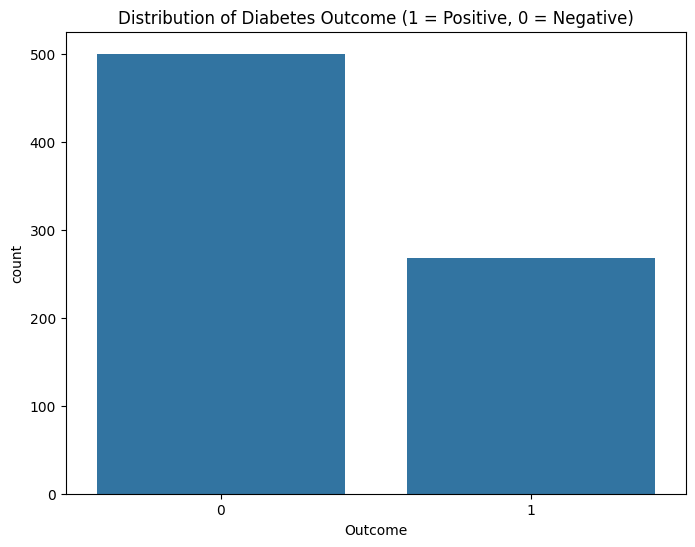

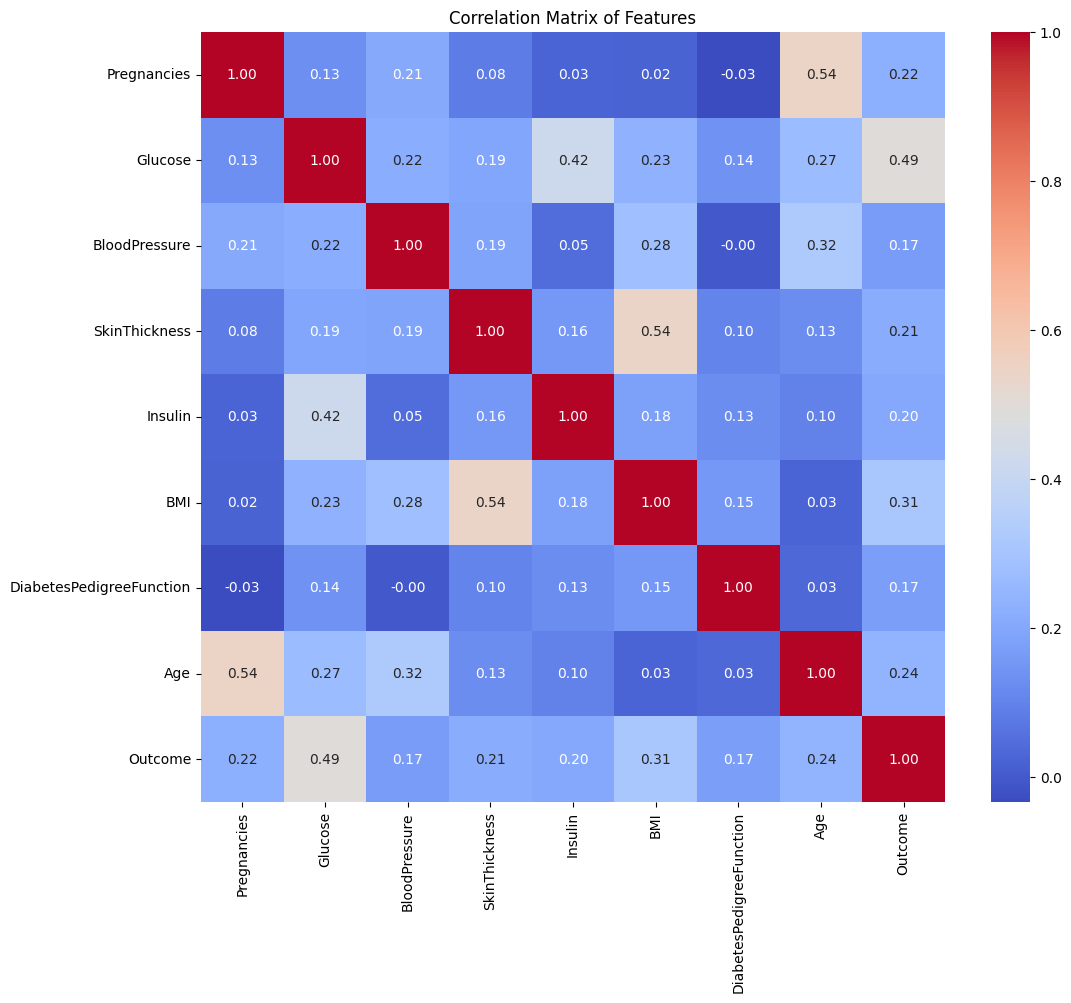

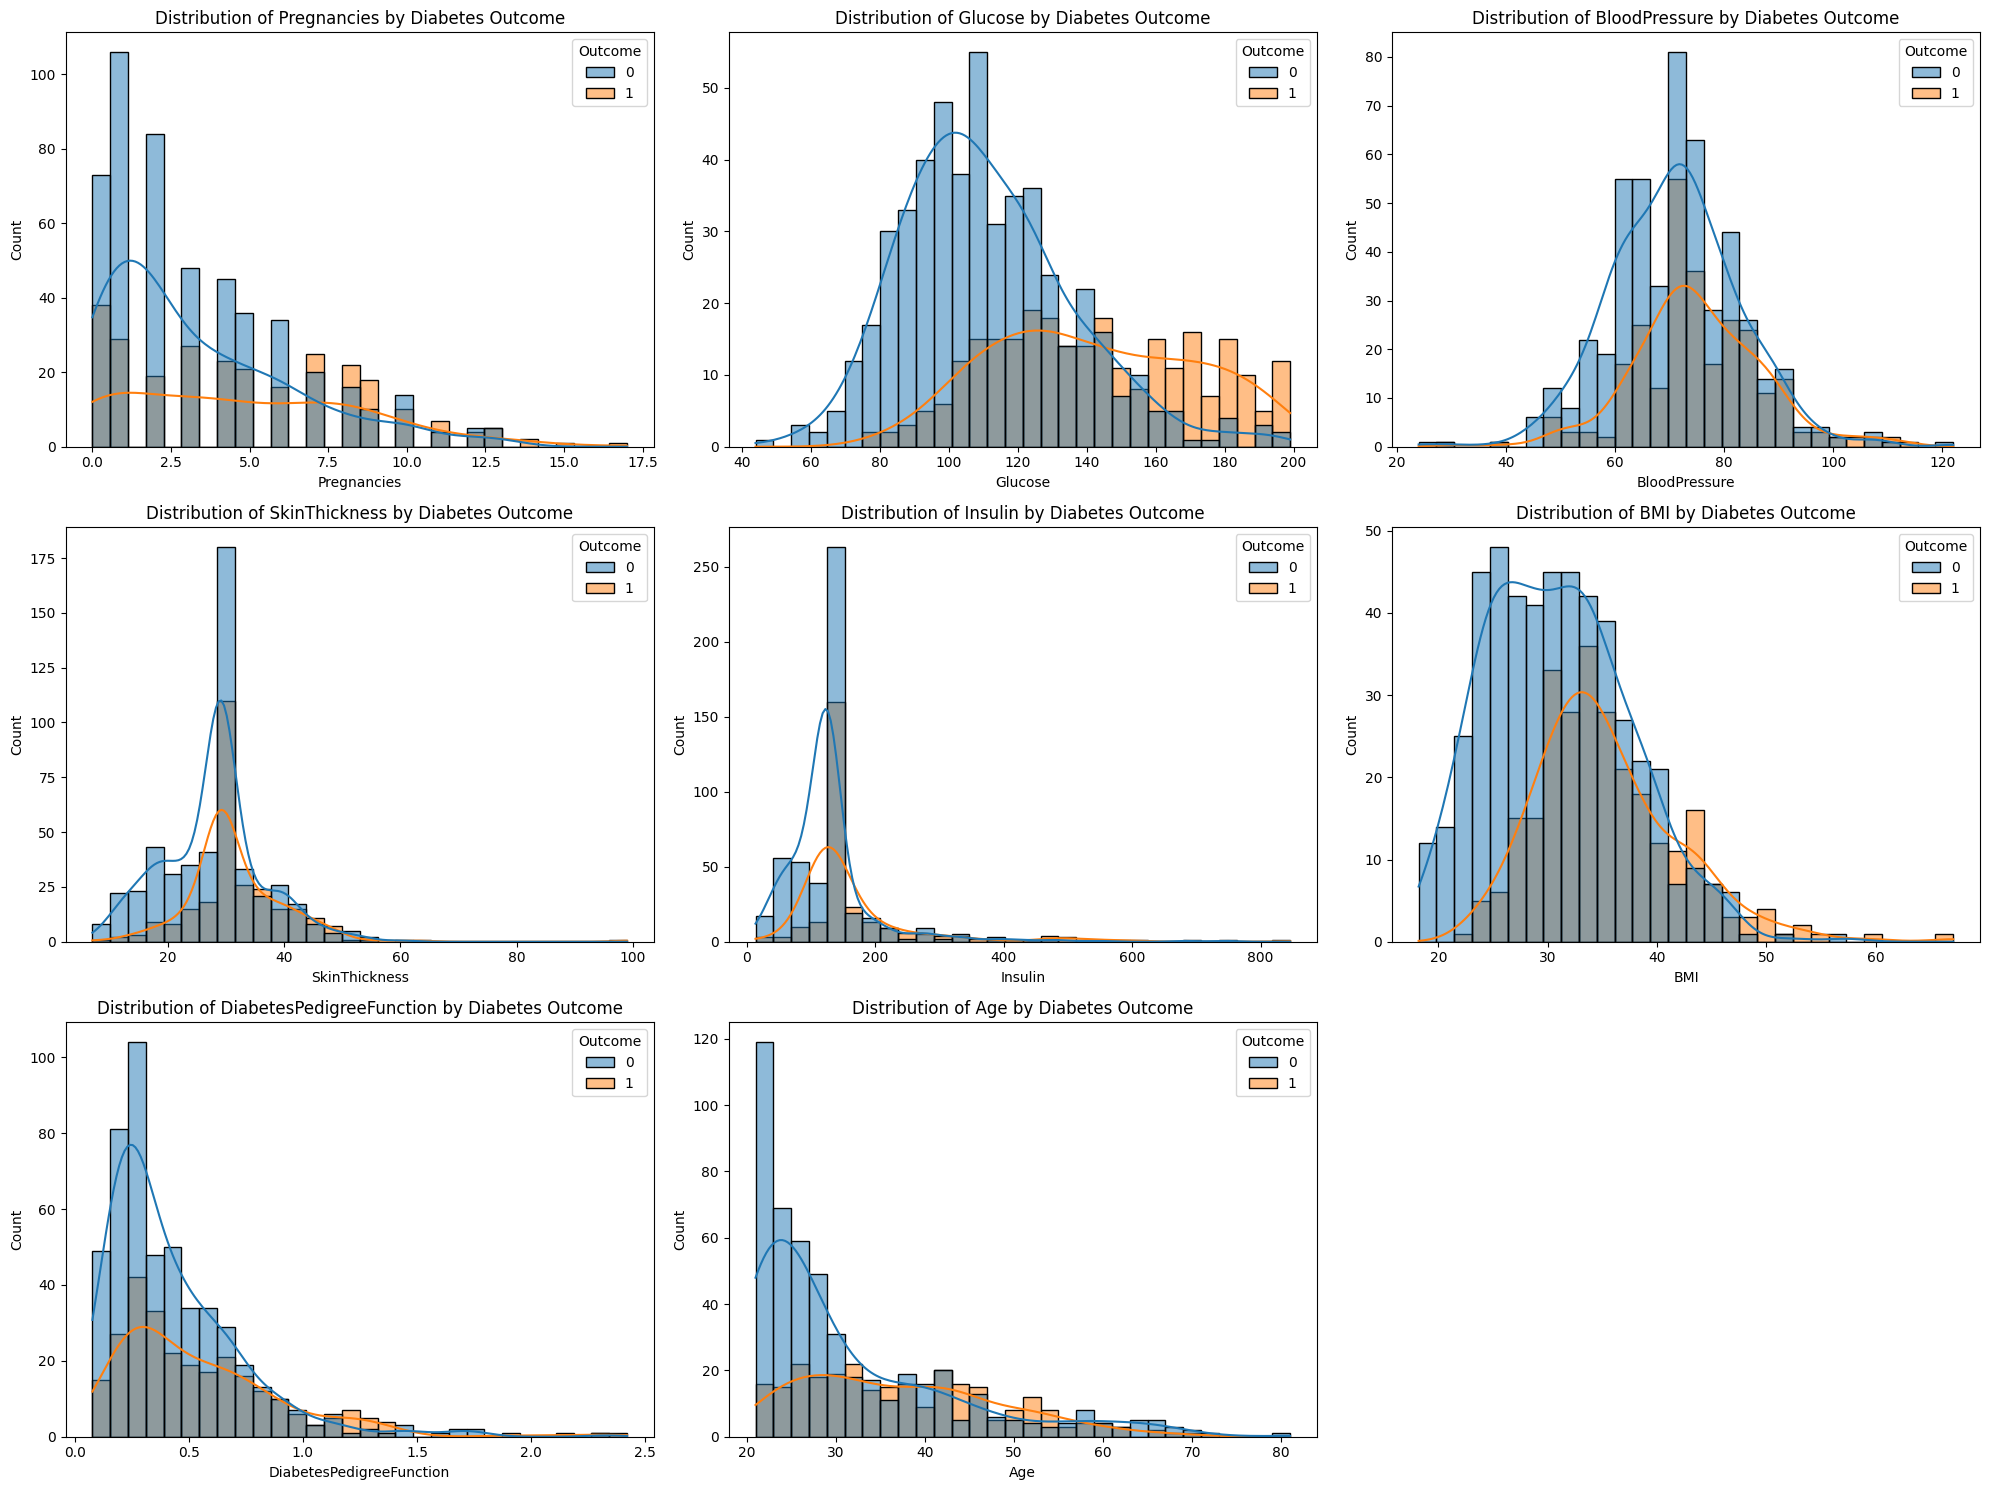

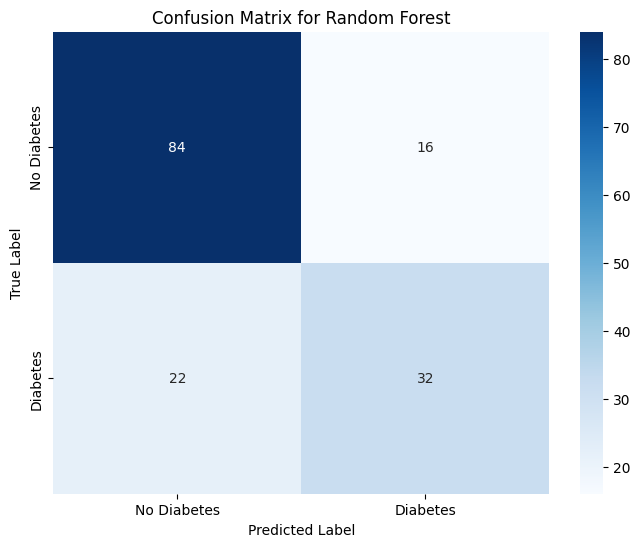

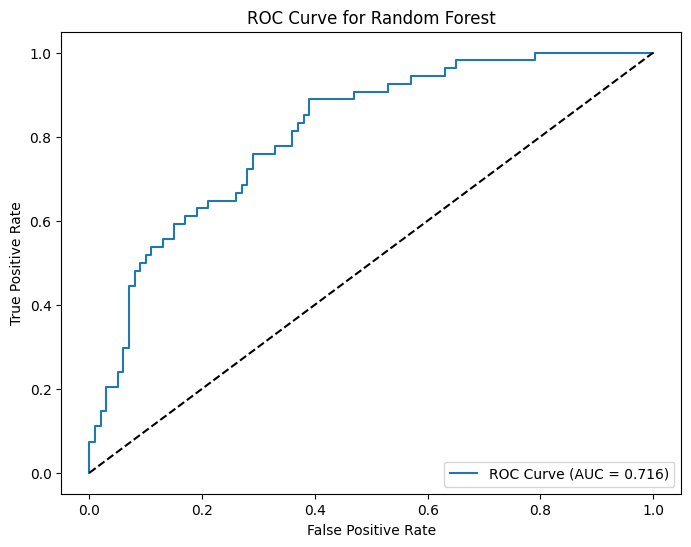

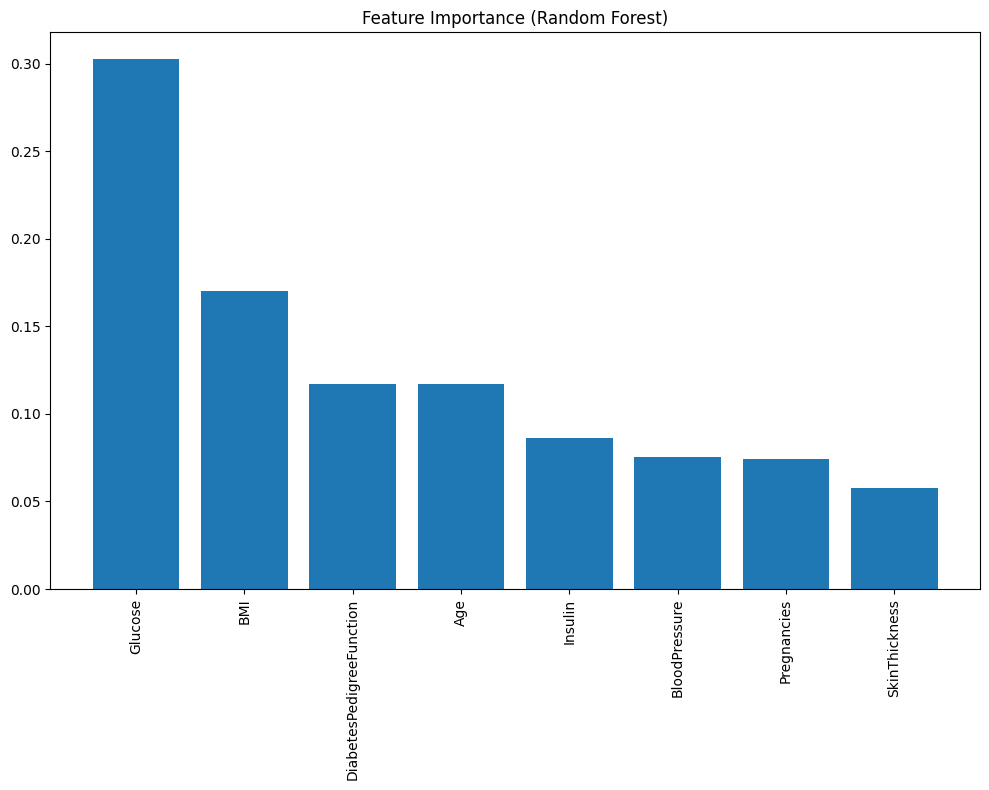

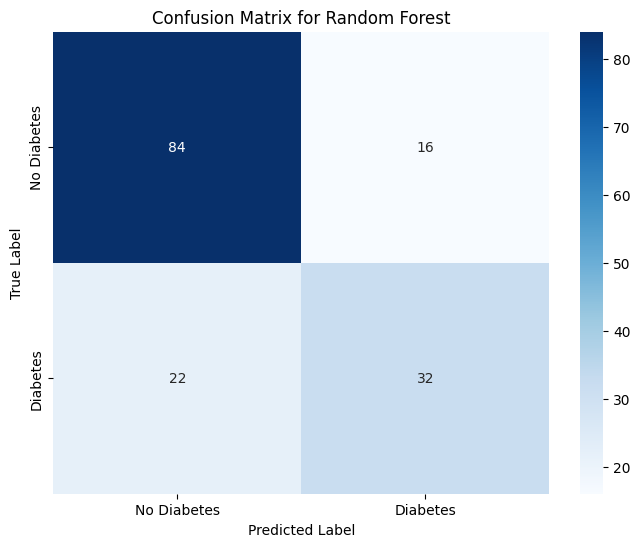

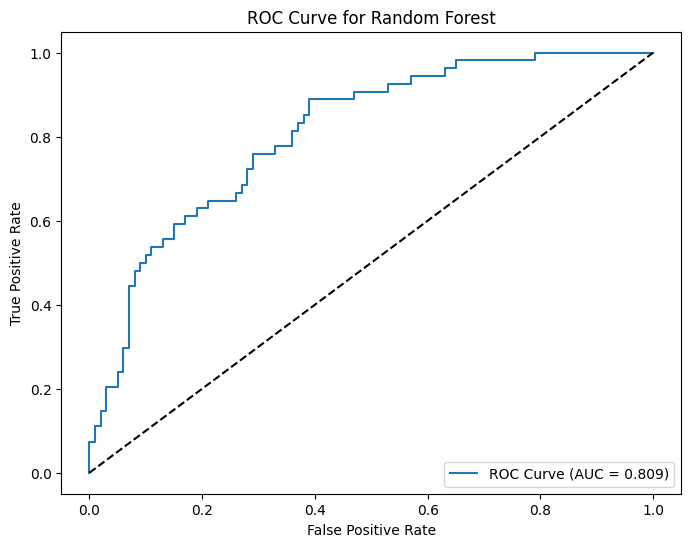

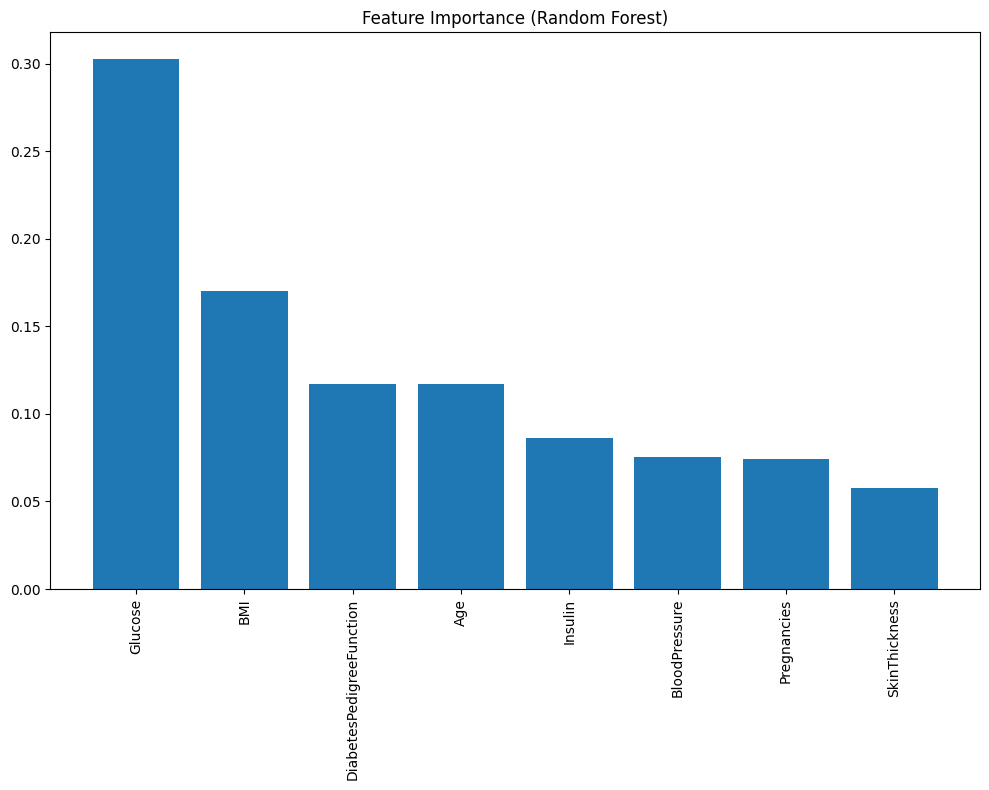


Random Forest Results:
{'accuracy': 0.7532467532467533, 'precision': 0.6666666666666666, 'recall': 0.5925925925925926, 'f1': 0.6274509803921569, 'roc_auc': np.float64(0.8085185185185184), 'best_params': {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}}


In [57]:
# Load and prepare the data
filepath = "data/diabetes.csv"
X_train_scaled, X_test_scaled, y_train, y_test, scaler, df_processed = load_and_prepare_diabetes_data(filepath)

# Visualize feature distributions
visualize_feature_distributions(df_processed)

# Define feature names
feature_names = df_processed.columns[:-1]  # Exclude the 'Outcome' column

##############################################################
# Train and evaluate models
best_model, best_model_name, results = train_and_evaluate_3_models(
    X_train_scaled, X_test_scaled, y_train, y_test, feature_names
)

# Print the best model and its parameters
print(f"Best Model: {best_model_name}")
print(f"Best Model Parameters: {results[best_model_name]['best_params']}")

# Print the comparison results
compare_results = pd.DataFrame(results).T
print("\nModel Comparison:")
print(compare_results[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']])
#########################################################
# CALL Random Forest Model only
print('################################################')
# Train and evaluate the Random Forest model
best_model, results = train_evaluate_diabetes_random_forest_model(
    X_train_scaled, X_test_scaled, y_train, y_test, feature_names
)

# Print results
print("\nRandom Forest Results:")
print(results)